write the cplex code for this,

fill an n x n matrix W with random numbers,

define two variable matrices, A and B, with one being n x r • r x n,

optimize for the best r and entries in A and B such that their product contains an approximation of W using some arbitrary loss

In [2]:
import numpy as np
from docplex.cp.model import CpoModel as Model
from docplex.cp.parameters import CpoParameters

n = 32
r = 8

In [3]:
np.random.seed(0)

# myparams = CpoParameters()
m = Model()

W = np.random.rand(n, n).round(6)

A = np.array(m.integer_var_list(r*n, 0, 1000))
B = np.array(m.integer_var_list(n*r, 0, 1000))

for i in range(n*r):
    m.add_constraint(A[i] * B[i] <= 1_000_000)
    m.add_constraint(A[i] * B[i] >= 0)


A_float = np.array([a/1000 for a in A]).reshape(n, r)
B_float = np.array([b/1000 for b in B]).reshape(r, n)

distance = (( (A_float @ B_float) - (W) )**2).sum()

m.minimize(distance)

In [8]:
solution = m.solve(log_output=True, TimeLimit=1200) 
# 0.3136016

 ! --------------------------------------------------- CP Optimizer 22.1.1.0 --
 ! Minimization problem - 512 variables, 512 constraints
 ! TimeLimit            = 1200
 ! Initial process time : 0.06s (0.06s extraction + 0.00s propagation)
 !  . Log search space  : 5103.2 (before), 5103.2 (after)
 !  . Memory usage      : 4.5 MB (before), 4.5 MB (after)
 ! Using parallel search with 6 workers.
 ! ----------------------------------------------------------------------------
 !          Best Branches  Non-fixed    W       Branch decision
                        0        512                 -
 + New bound is 0
                     1000        128    1   F   321  = _INT_72
                     1000        191    2   F   495  = _INT_428
 *      337.2470      531  2.52s        3      (gap is 100.0%)
        337.2470     1000          1    3         0  = _INT_79
        337.2470     1000        129    4       117 != _INT_262
        337.2470     1000          1    5         0  = _INT_259
      

In [18]:
A_solution = []
B_solution = []

for i in range(n*r):
    A_solution.append(solution[A.tolist()[i]] / 1000)
    B_solution.append(solution[B.tolist()[i]] / 1000)

In [19]:
W_hat = np.array(A_solution).reshape(n, r) @ np.array(B_solution).reshape(r, n)

In [20]:

((W_hat - W)**2).sum()


71.275490053651

In [21]:
W_hat

array([[0.436539, 0.716294, 0.636358, ..., 0.730071, 0.475801, 0.622233],
       [0.32959 , 0.450622, 0.381763, ..., 0.456496, 0.482327, 0.460023],
       [0.372961, 0.380336, 0.588498, ..., 0.359433, 0.659108, 0.285398],
       ...,
       [0.349307, 0.577485, 0.447578, ..., 0.53997 , 0.207165, 0.476474],
       [0.338115, 0.546209, 0.495079, ..., 0.60827 , 0.819153, 0.581042],
       [0.42883 , 0.644572, 0.541079, ..., 0.689737, 0.39085 , 0.522681]])

In [17]:
W

array([[0.548814, 0.715189, 0.602763, ..., 0.414662, 0.264556, 0.774234],
       [0.45615 , 0.568434, 0.01879 , ..., 0.110375, 0.65633 , 0.138183],
       [0.196582, 0.368725, 0.820993, ..., 0.716327, 0.289406, 0.183191],
       ...,
       [0.77311 , 0.21687 , 0.90315 , ..., 0.522176, 0.853606, 0.889448],
       [0.220104, 0.622894, 0.111496, ..., 0.771225, 0.012171, 0.32283 ],
       [0.229567, 0.506863, 0.736853, ..., 0.6205  , 0.639622, 0.94854 ]])

#### Alternate Solution

In [63]:
np.random.seed(0)
from tqdm import tqdm

n = 512
r = 32
# myparams = CpoParameters()
m = Model()

W = np.random.rand(n, n)
Dupe_count = 32
learning_rate = 0.1
EPOCHS = 10000

all_best_distances = [10e8]

A = [np.random.rand(n, r) for _ in range(Dupe_count)]
B = [np.random.rand(r, n) for _ in range(Dupe_count)]

for i in tqdm(range(EPOCHS)):

    possibles = []

    for a, b in zip(A, B):
        possibles.append(a@b)

    distances =[]
    for idx, poss in enumerate(possibles):
        distances.append(( ((poss) - (W) )**2).sum())


    if np.min(distances) >= np.min(all_best_distances):
        continue

    all_best_distances.append(np.min(distances))

    best_index = np.argmin(distances)

    A_ = [((np.random.rand(n, r)-0.5) * learning_rate) + A[best_index] for _ in range(Dupe_count)]
    B_ = [((np.random.rand(r, n)-0.5) * learning_rate) + B[best_index] for _ in range(Dupe_count)]

    # print(A_)

    A = A_
    B = B_

    lowest_distance = np.min(distances)

    if i % 100 == 0:
        print(f'Reached Epoch {i} with distance {lowest_distance}')
        learning_rate -= 0.00001

  0%|          | 3/10000 [00:00<15:37, 10.67it/s]

Reached Epoch 0 with distance 14916940.625825044


  1%|          | 103/10000 [00:08<13:54, 11.86it/s]

Reached Epoch 100 with distance 11685295.867872179


  2%|▏         | 203/10000 [00:17<13:40, 11.95it/s]

Reached Epoch 200 with distance 9076935.61565633


  3%|▎         | 303/10000 [00:25<13:41, 11.80it/s]

Reached Epoch 300 with distance 7171811.335880076


  4%|▍         | 403/10000 [00:34<13:26, 11.90it/s]

Reached Epoch 400 with distance 5907279.6102469815


  5%|▌         | 503/10000 [00:43<13:41, 11.56it/s]

Reached Epoch 500 with distance 5076918.6911823


100%|██████████| 10000/10000 [12:22<00:00, 13.47it/s]


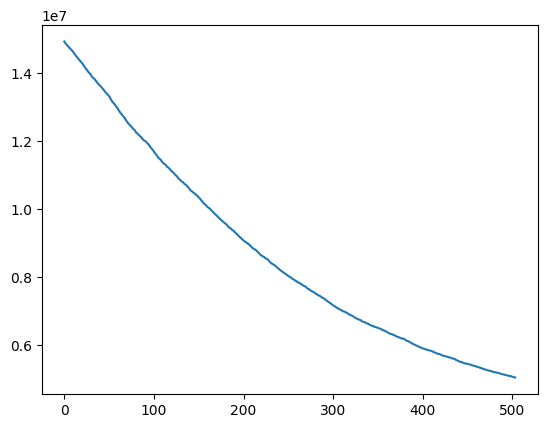

In [60]:
import matplotlib.pyplot as plt
plt.plot(all_best_distances[1:])

In [61]:
all_best_distances[-1]

5054371.698008159

In [62]:
((A[best_index] @ B[best_index] - W)**2).sum()

5059499.069388429